## Lab Exame - CMC-13
### Equipe:


### 1. Preparação dos dados

#### Imports

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import geopandas as gpd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import xgboost as xgb



In [ ]:
df_train = pd.read_csv('./apartments_for_rent_train.csv', index_col=0, sep=',')
df_test = pd.read_csv('./apartments_for_rent_test.csv', index_col=0, sep=',')
print('Size of dfs are: \n\tdf_train:',
      df_train.shape,
      '\n\tdf_test:',
      df_test.shape)
df_train.head()

Vamos avaliar a qualidade dos dados e prepará-los para a modelagem.

Vamos começar avaliando a quantidade de valores únicos que temos por coluna

In [38]:
df_train.nunique()

id               8001
category            3
title            7465
body             7963
amenities        2071
bathrooms           5
bedrooms            6
currency            1
fee                 1
pets_allowed        3
price            1515
price_display    1516
price_type          3
square_feet       888
address          5165
cityname         1331
state              50
latitude         2029
longitude        2024
source             12
time             5347
dtype: int64

Vemos que podemos retirar as colunas `currency` e  `fee`, uma vez que elas apresentam apenas um valor único. Todas os dados estão em dólares e os imóveis não apresentam taxa. 

Em paralelo, podemos remover junto a coluna `source` e `time` pois se referem a informações da obtenção dos dados e não serão úteis para nosso modelo.

Vemos também que as colunas `price_display` e `price_type` não são relevantes para o modelo, tendo em vista que já possuímos a variável `price`.

Por fim, podemos remover as colunas `id`, `title` e `body`, já que não trazem informações relevantes para a modelagem, são úicas.

Outro ponto relevante é que 99% dos imóveis estão na categoria de apartamento. Essa variável tem, portanto, baixo poder explicativoa


In [39]:
# count the number of null values in each column
df_train.isnull().sum()

id                  0
category            0
title               0
body                0
amenities        2516
bathrooms          28
bedrooms            5
currency            0
fee                 0
pets_allowed     3400
price               0
price_display       0
price_type          0
square_feet         0
address          2824
cityname           60
state              60
latitude            9
longitude           9
source              0
time                1
dtype: int64

In [40]:
df_train.dtypes

id                 int64
category          object
title             object
body              object
amenities         object
bathrooms        float64
bedrooms         float64
currency          object
fee               object
pets_allowed      object
price              int64
price_display     object
price_type        object
square_feet        int64
address           object
cityname          object
state             object
latitude         float64
longitude         object
source            object
time             float64
dtype: object

Vemos que temos colunas com muitos dados faltantes, esse é o caso de `pets_allowed`, `address`, `city` e `state`. Podemos assim, descartar as colunas `pets_allowed` e `address` para a modelagem. 

Como a informação de localização é bem relevante (heurística) para o modelo, vamos tentar contornar essa falta de dados a partir da biblioteca `geopandas` e da biblioteca `geopy` com os dados de latitude e longitude.

In [41]:
df_train.drop(
    columns=[
        "currency",
        "fee",
        # "source",
        "time",
        "price_display",
        "price_type",
        "id",
        "category",
        "title",
        "body",
        "address",
        # "pets_allowed",
        # "amenities",
        "cityname",
        "state",
    ],
    inplace=True,
)

# tirando as linhas com valores nulos
df_train.dropna(inplace=True)

#### Localização Geográfica

Vamos avaliar as informações de Latitude e Longitude

In [42]:
# Função para corrigir a formatação dos dados
def corrigir_formato(valor):
    if isinstance(valor, str):
        # Detectar se o valor tem dois pontos (milhar incorreto)
        if re.match(r'^-?\d+\.\d+\.\d+$', valor):
            # Remover os pontos de milhar
            valor = valor.replace('.', '', 1)  # Remove apenas o primeiro ponto
        valor = valor.replace(',', '.')  # Garantir que a vírgula seja substituída por ponto
    return float(valor)

# Aplicar a correção na coluna específica (substitua 'longitude' pelo nome da coluna correta)
df_train['longitude'] = df_train['longitude'].dropna().apply(corrigir_formato)
df_train['latitude'] = df_train['latitude'].dropna().apply(corrigir_formato)
df_test['longitude'] = df_test['longitude'].dropna().apply(corrigir_formato)
df_test['latitude'] = df_test['latitude'].dropna().apply(corrigir_formato)

# percebemos que os valores estão multiplicados por 10
df_train[['latitude', 'longitude']] = df_train[['latitude', 'longitude']]/10
df_test[['latitude', 'longitude']] = df_test[['latitude', 'longitude']]/10

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)


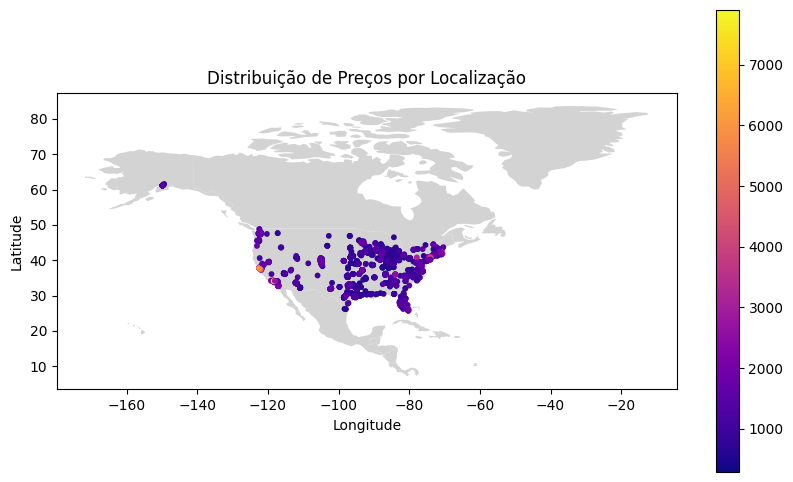

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Criar uma GeoDataFrame
gdf = gpd.GeoDataFrame(df_train, geometry=gpd.points_from_xy(df_train.longitude, df_train.latitude))

# Substitua pelo caminho do seu arquivo baixado
file_path = "./ne_110m_admin_0_countries.zip"

# Carregar o conjunto de dados de países
world = gpd.read_file(file_path)

# Verifique as colunas disponíveis
print(world.columns)

# Ajuste este filtro com base nas colunas disponíveis
# Por exemplo, se a coluna for 'region_un' em vez de 'continent'
north_america = world[world['CONTINENT'] == 'North America']

# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar o mapa da América do Norte
north_america.plot(ax=ax, color='lightgrey')

# Plotar os pontos com a coloração baseada no preço
gdf.plot(ax=ax, column='price', cmap='plasma', markersize=10, legend=True)

# Adicionar título e rótulos
plt.title('Distribuição de Preços por Localização')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Exibir o gráfico
plt.show()


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


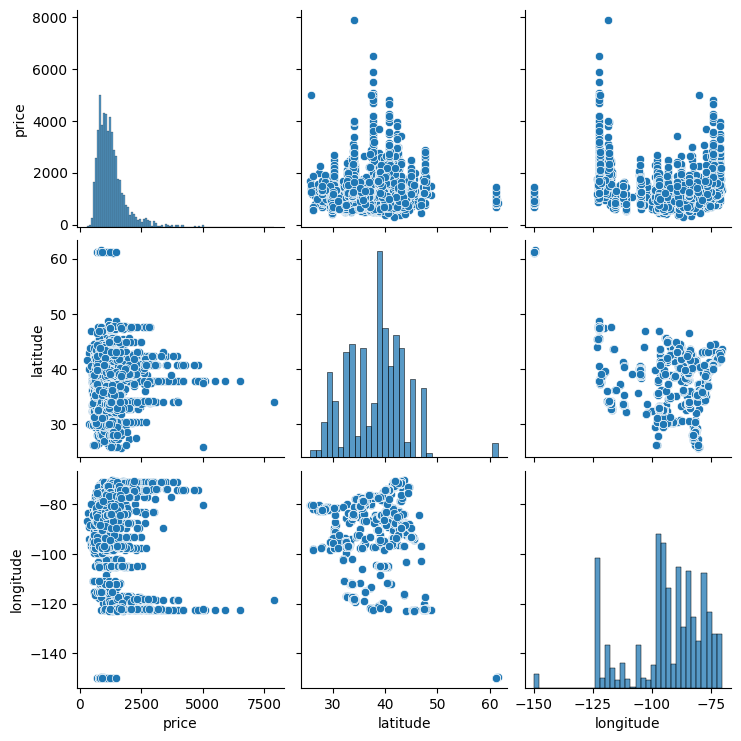

In [44]:
sns.pairplot(df_train[['price', 'latitude', 'longitude']])

Vemos que a localização geográfica é um dado relevante para o modelo, uma vez que a localização do imóvel pode influenciar no preço. Temo uma concentração de valores mais altos na costa oeste dos EUA.

Com a latitude e longitude separadas é possível desconsiderar as variáveis cidade e estado pois as informações de posição geográfica já estarão contempladas. É melhor tratarmos os dados de lat e long para o modelo pois eles representam variáveis numéricas e não categóricas. Comparando com os dados de cidade e estado, temos uma informação muito granular. Todavia, tratar com lat e long pode ser mais complexo, uma vez que a relação entre essas variáveis e o preço pode não ser linear (o que de fato não é). 

Uma alternativa seria criar uma variável que represente a distância do centro da cidade, ou de um ponto de referência, para o imóvel. Isso poderia ser feito a partir de uma biblioteca de geolocalização, como a `geopy`.

Outra alternativa é determinar clusters de localidades, a partir de algoritmos de clusterização, e utilizar esses clusters como variáveis categóricas para o data set de teste.

Vamos tomar a segunda alternativa.

     latitude   longitude        price
0   39.364227 -118.469700  2078.545455
1   36.597527  -86.541112  1108.653061
2   38.335850  -99.725550  3697.500000
3   37.871528  -90.885954   799.366667
4   38.158374  -82.947464  1429.205128
..        ...         ...          ...
95  45.589004 -121.914276  1379.000000
96  40.156064  -85.322490  1461.320000
97  39.320717  -84.286600  1496.609756
98  36.808810  -92.193058   543.193548
99  40.342404  -93.092392  1841.040000

[100 rows x 3 columns]


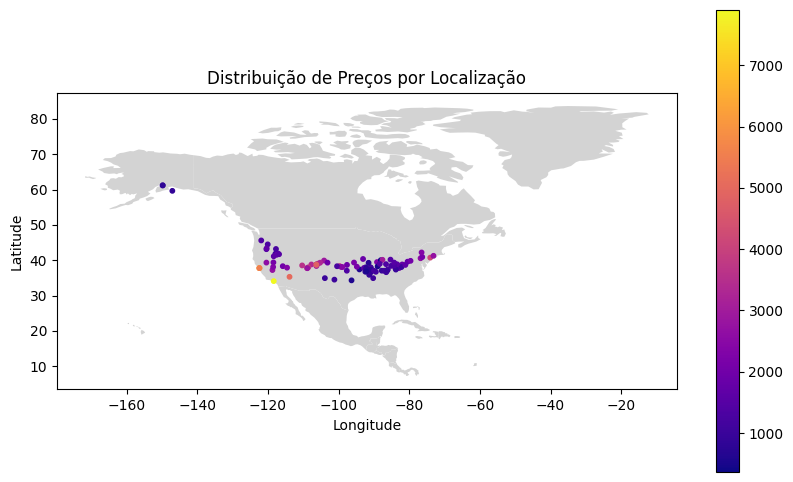

In [45]:
# Definir o número de clusters
num_clusters = 100

# Preparar os dados para o clustering
location_data = df_train[['latitude', 'longitude', 'price']]

# Aplicar o KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_train['location_cluster'] = kmeans.fit_predict(location_data)

# retornar o centro do cluster
location_clusters = pd.DataFrame(kmeans.cluster_centers_, columns=['latitude', 'longitude', 'price'])
print(location_clusters)

gdf = gpd.GeoDataFrame(location_clusters, geometry=gpd.points_from_xy(location_clusters.longitude, location_clusters.latitude))


# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar o mapa da América do Norte
north_america.plot(ax=ax, color='lightgrey')

# Plotar os pontos com a coloração baseada no preço
gdf.plot(ax=ax, column='price', cmap='plasma', markersize=10, legend=True)

# Adicionar título e rótulos
plt.title('Distribuição de Preços por Localização')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Exibir o gráfico
plt.show()


# # Verificar os clusters gerados
# df_train[['latitude', 'longitude', 'price', 'location_cluster']].head()


#### Amenities & pets_allowed

Como temos várias opções dentro da coluna `amenities`, vamos segmentar essas informações em colunas separadas para cada amenidade, transformando em uma variável booleana. O mesmo para a coluna `pets_allowed`.

In [46]:
# criando colunas para 'AC', 'Parking' e 'Pool'
df_train['pool'] = df_train['amenities'].str.contains('Pool', case=1, na=0).astype(int)
df_train['ac'] = df_train['amenities'].str.contains('AC', case=1, na=0).astype(int)
df_train['parking'] = df_train['amenities'].str.contains('Parking', case=1, na=0).astype(int)
df_train['hot_tub'] = df_train['amenities'].str.contains('Hot Tub',case=1,na=0).astype(int)
df_train.drop(columns=["amenities"], inplace=True)

# fazendo o mesmo para pets_allowed
df_train['cats'] = df_train['pets_allowed'].str.contains('Cats',case=1,na=0).astype(int)
df_train['dogs'] = df_train['pets_allowed'].str.contains('Dogs',case=1,na=0).astype(int)
df_train.drop(columns=["pets_allowed"], inplace=True)

Vamos avaliar os pares e correlacionar as variáveis via `pairplot`

c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


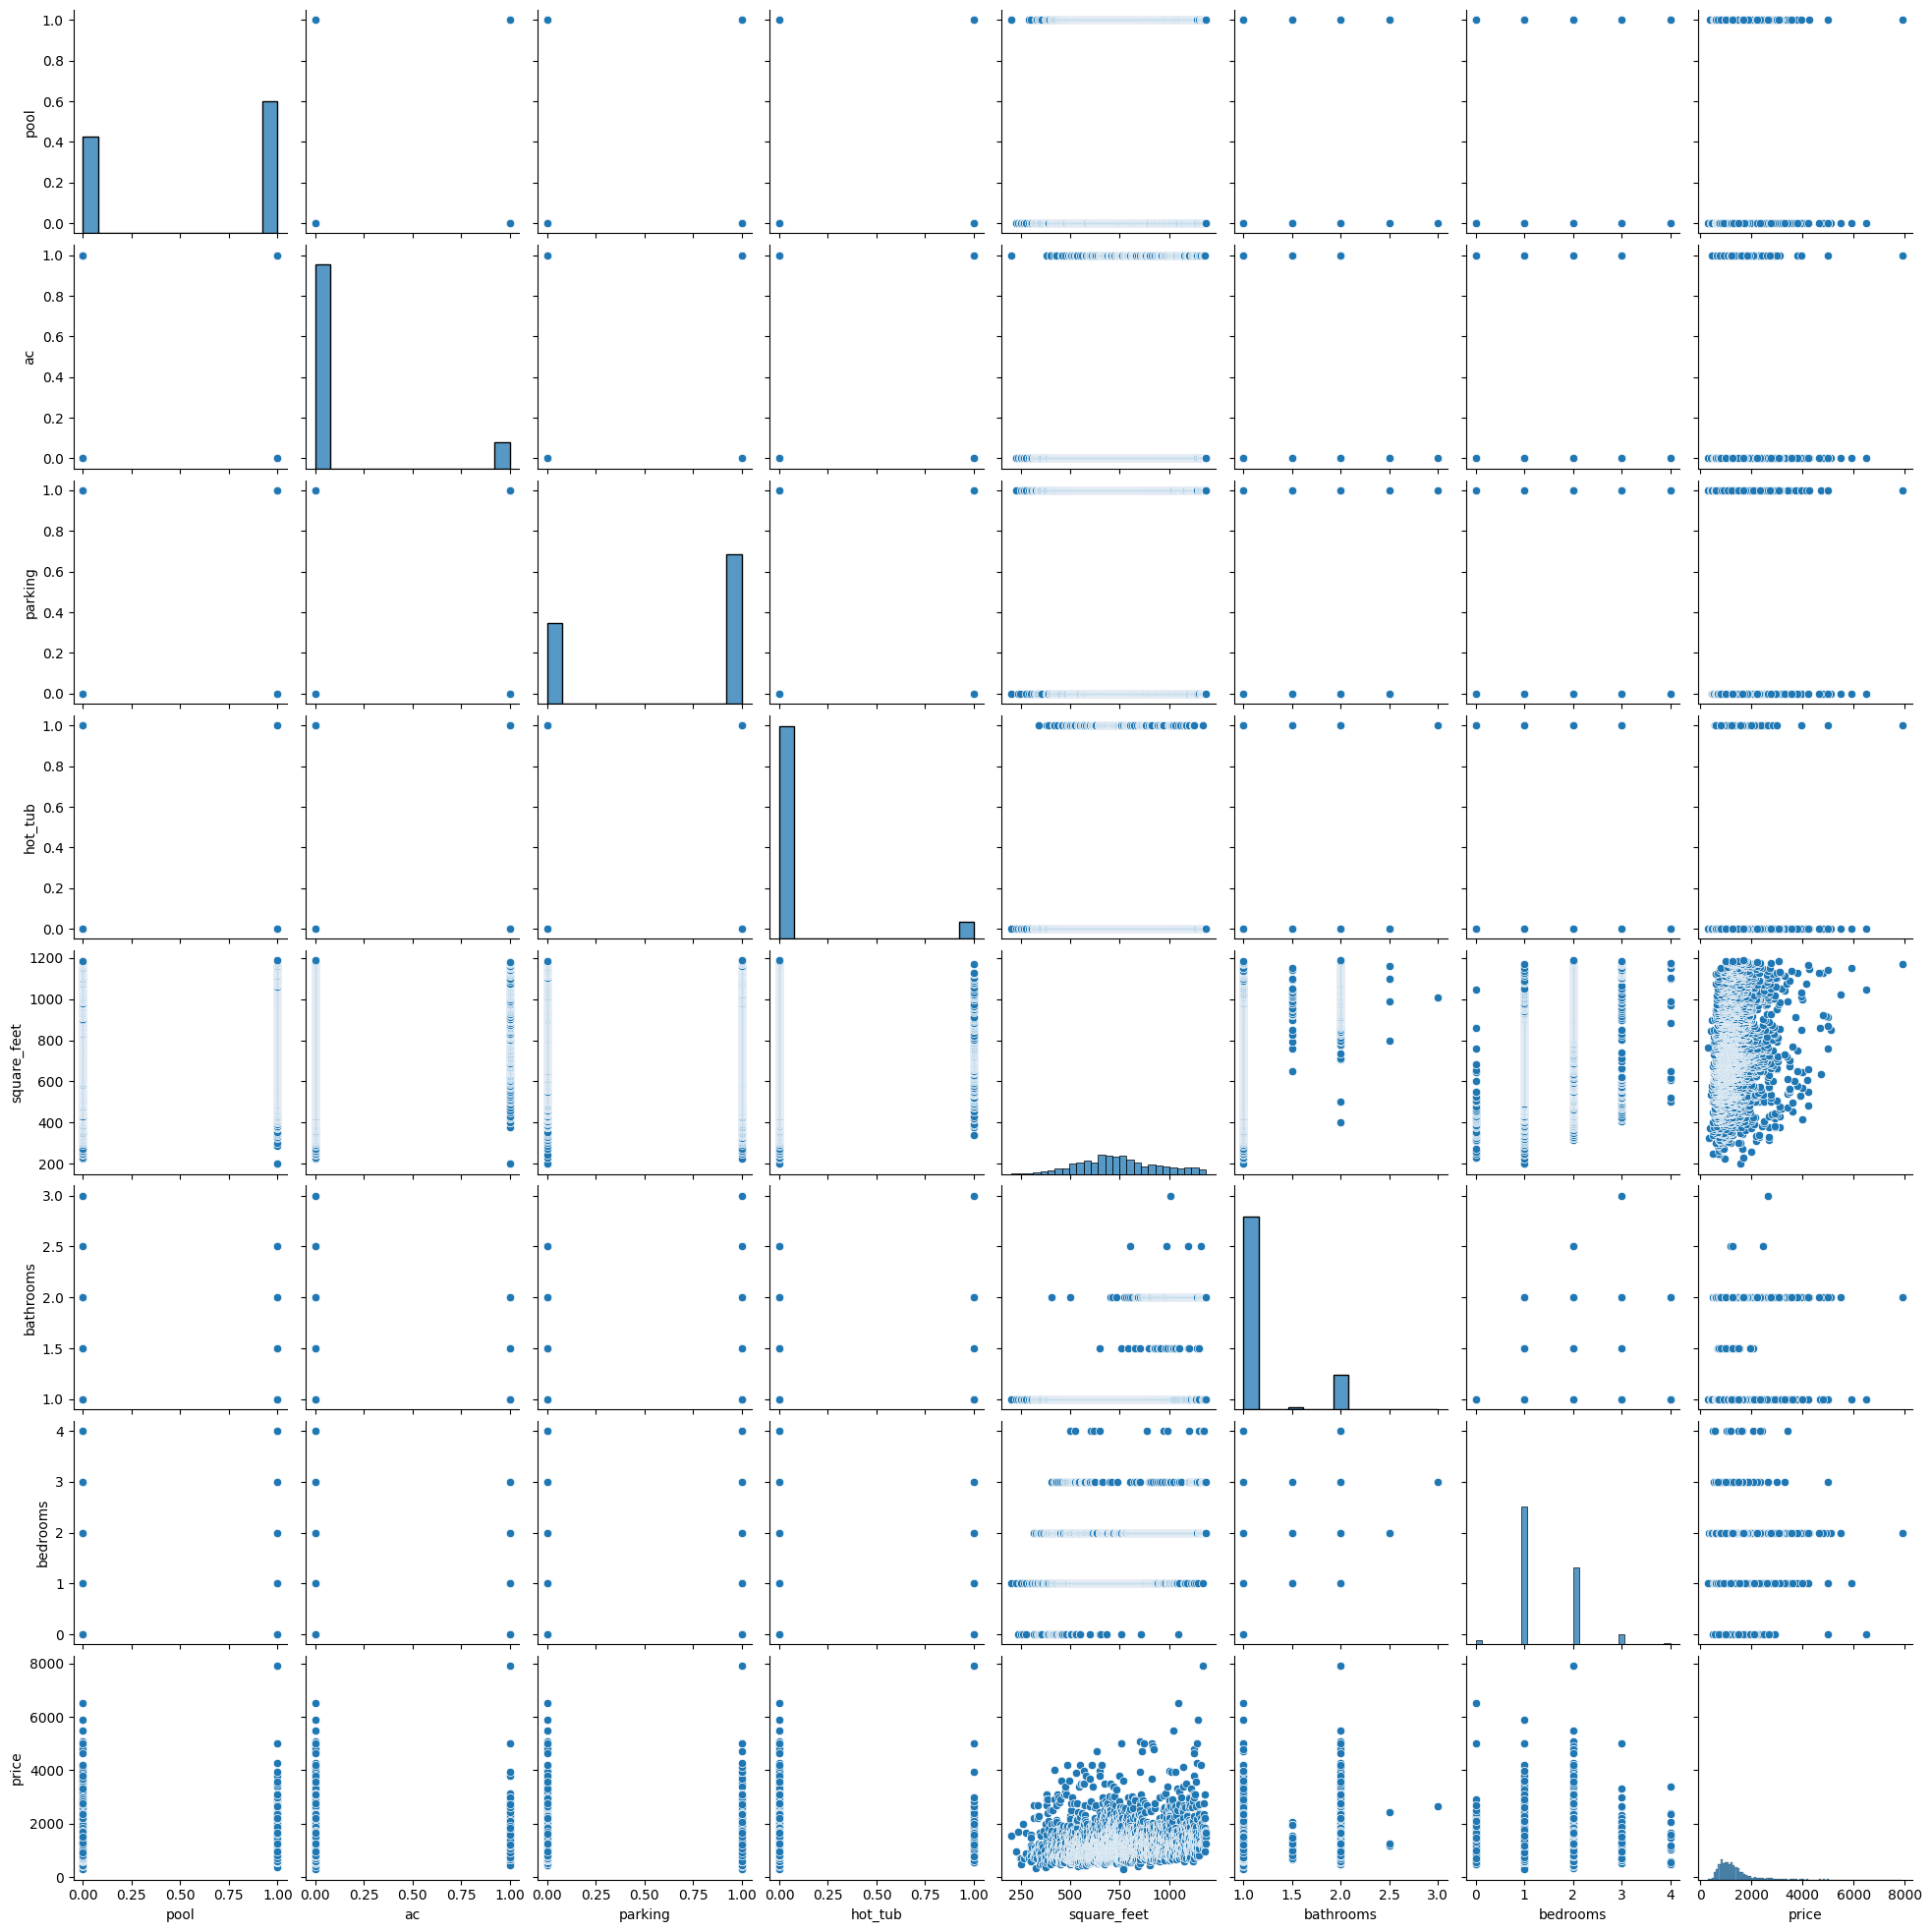

In [47]:
sns.pairplot(df_train[['pool', 'ac', 'parking', 'hot_tub',
             'square_feet', 'bathrooms', 'bedrooms', 'price']])

Observa-se que o gráfico de dispersão de preços aparenta ter outliers. Cria-se então o gráfico de boxplot do preço dos imóveis.

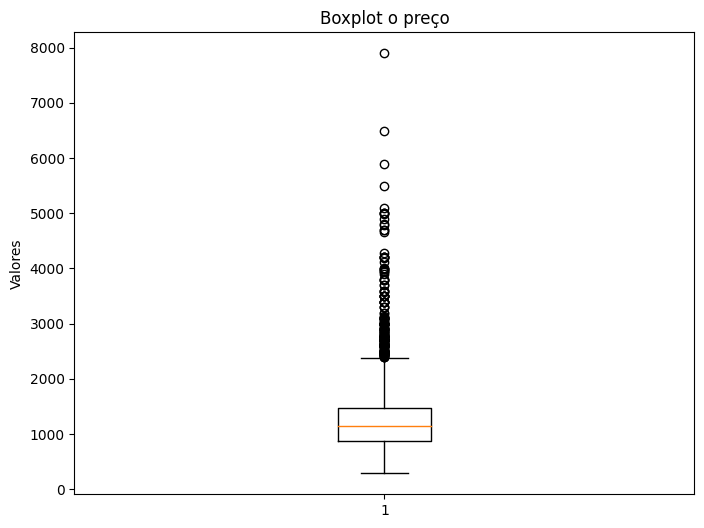

In [48]:
# Criar o boxplot do preço
plt.figure(figsize=(8, 6))
plt.boxplot(df_train['price'])
plt.title('Boxplot o preço')
plt.ylabel('Valores')
plt.show()

De fato o dataframe de treinamento possui muitos outliers. Verifica-se a quantidade de amostras perdidas ao desconsiderar tais outliers do dataframe de treinamento.

In [49]:
print(f"Linhas totais do dataframe: {df_train.shape[0]}")
print(f"Linhas a com valores outliers: {df_train[df_train['price'] > 2500].shape[0]}")
print(f"Percentual de linhas a desconsiderar: {df_train[df_train['price'] > 2500].shape[0]/df_train.shape[0]*100}%")

Linhas totais do dataframe: 3162
Linhas a com valores outliers: 154
Percentual de linhas a desconsiderar: 4.870335230866541%


Como somene 5% dos imóveis possuem preços acima de 2500, tais imóveis serão desconsiderados para o treinamento dos modelos

In [50]:
df_train = df_train[df_train['price'] < 2500]

c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


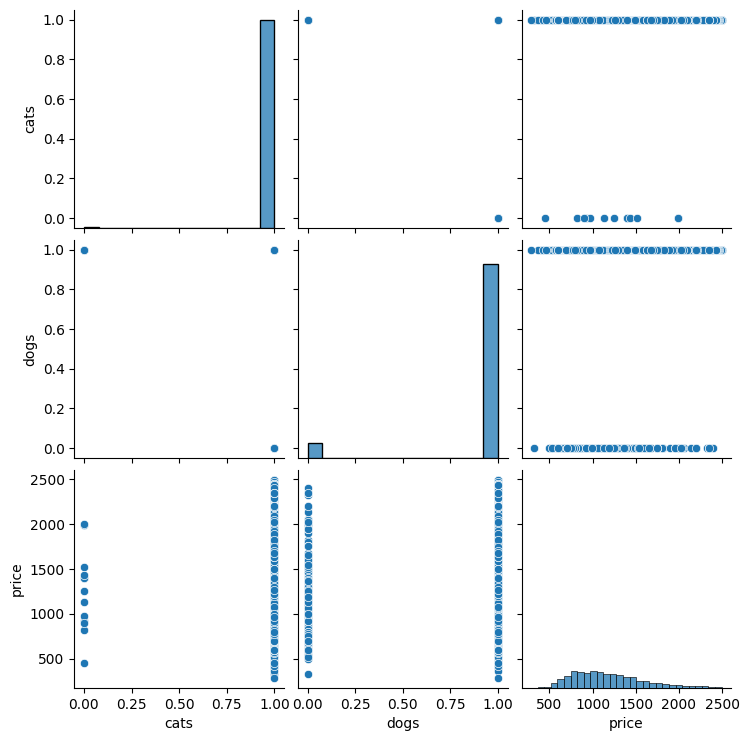

In [51]:
sns.pairplot(df_train[['cats','dogs','price']])

Percebe-se que tanto imóveis que aceitam gatos quanto imóveis que aceitam cachorros tendem a ter preços maiores.

In [52]:
df_train['source'].unique()

array(['ListedBuy', 'RentDigs.com', 'RentLingo', 'RENTOCULAR',
       'RealRentals', 'rentbits', 'RENTCaf?1576253157', 'Listanza',
       'tenantcloud'], dtype=object)

In [53]:
df_train.groupby('source',axis=0)['price'].describe()

C:\Users\rafae\AppData\Local\Temp\ipykernel_4712\3791428311.py:1: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df_train.groupby('source',axis=0)['price'].describe()


,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
Listanza,1.0,1950.000000,NaN,1950.0,1950.0,1950.0,1950.0,1950.0
ListedBuy,17.0,1021.352941,429.020242,665.0,750.0,835.0,1092.0,2093.0
RENTCaf?1576253157,1.0,995.000000,NaN,995.0,995.0,995.0,995.0,995.0
RENTOCULAR,3.0,1631.000000,327.830749,1295.0,1471.5,1648.0,1799.0,1950.0
RealRentals,3.0,1738.666667,352.274514,1332.0,1633.0,1934.0,1942.0,1950.0
RentDigs.com,888.0,1274.912162,414.316319,455.0,980.0,1210.0,1525.0,2495.0
RentLingo,2088.0,1141.157088,402.119237,288.0,825.0,1075.0,1370.0,2495.0
rentbits,2.0,1045.000000,70.710678,995.0,1020.0,1045.0,1070.0,1095.0
tenantcloud,1.0,750.000000,NaN,750.0,750.0,750.0,750.0,750.0


Apesar de existirem diferenças nos preços de fontes distintas, são poucas observações de fontes diferentes de 'RentLingo'. Assim, esse atributo será desconsiderado.

In [54]:
df_train.drop(columns=["source"], inplace=True)

# ficamos assim apenas com as colunas
df_train.columns

Index(['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude',
       'longitude', 'location_cluster', 'pool', 'ac', 'parking', 'hot_tub',
       'cats', 'dogs'],
      dtype='object')

##### Preparação para o DF de Teste

In [55]:
df_test = pd.read_csv('./apartments_for_rent_test.csv', index_col=0)
df_test = df_test[['amenities', 'bathrooms', 'bedrooms', 'pets_allowed', 'price',
                   'square_feet', 'latitude', 'longitude']]

# Excluindo valores inexistentes
df_test.dropna(inplace=True)

# criando colunas para 'AC', 'Parking' e 'Pool'
df_test['pool'] = df_test['amenities'].str.contains('Pool', case=1, na=0).astype(int)
df_test['ac'] = df_test['amenities'].str.contains('AC', case=1, na=0).astype(int)
df_test['parking'] = df_test['amenities'].str.contains('Parking', case=1, na=0).astype(int)
df_test['hot_tub'] = df_test['amenities'].str.contains('Hot Tub', case=1, na=0).astype(int)

# Processando latitude e longitude
df_test['latitude'] = df_test['latitude']/10
df_test['longitude'] = df_test['longitude'].apply(corrigir_formato)/10
df_test['location_cluster'] = kmeans.fit_predict(df_test[['latitude', 'longitude', 'price']])

# Criando colunas para verificar se aceitam gatos ou cachorros
df_test['cats'] = df_test['pets_allowed'].str.contains('Cats', case=1, na=0).astype(int)
df_test['dogs'] = df_test['pets_allowed'].str.contains('Dogs', case=1, na=0).astype(int)

# Excluindo colunas desnecessarias
df_test.drop(['amenities', 'pets_allowed'], inplace=True, axis=1)
df_test

,bathrooms,bedrooms,price,square_feet,latitude,longitude,pool,ac,parking,hot_tub,location_cluster,cats,dogs
8002,2.0,2.0,1699,1188,34.0072,-84.0034,1,0,0,0,18,1,1
8003,1.0,2.0,1695,1189,43.0724,-89.4003,0,0,1,0,18,1,1
8009,2.0,2.0,1800,1190,43.0724,-89.4003,0,0,1,0,28,1,0
8011,2.0,2.0,1503,1190,37.6202,-77.6128,1,0,1,0,25,1,1
8012,1.0,1.0,1470,1190,32.0057,-102.1036,0,0,1,0,72,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9769,3.0,4.0,1750,2397,30.0021,-95.2555,0,0,0,0,42,1,1
9782,2.0,4.0,1699,2425,32.5942,-96.7624,0,0,0,0,18,1,1
9783,2.0,4.0,1699,2426,34.1241,-84.0331,0,0,0,0,18,1,1
9792,2.0,3.0,1549,2446,32.5900,-96.9436,0,0,0,0,0,1,1


# Modelos

Todos os modelos utilizarão o método de Cross Validation com K-Folds (K=10) para atualização de hiperparâmetros (se aplicável)

In [56]:
df_train = df_train.loc[df_train.price < 2500]
y_train = df_train['price']
X_train = df_train.drop(columns=['price'])

y_test = df_test['price']
X_test = df_test.drop(columns=['price'])

def min_max_normalize(X):
    return (X - X.min()) / (X.max() - X.min())

y_train = min_max_normalize(y_train)
y_test = min_max_normalize(y_test)


## KNN
 
 Os modelos KNN se beneficiam de uma normalização dos dados. Vamos normalizar os dados e aplicar o modelo.

In [57]:
X_train = min_max_normalize(X_train)
X_test = min_max_normalize(X_test)

X_train = X_train[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]
X_test = X_test[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]

In [58]:
# Definir os hiperparâmetros a serem ajustados
knn_params = {'n_neighbors': range(1, 31)}

# Inicializar o modelo
knn = KNeighborsRegressor()

# Configurar a validação cruzada com GridSearchCV
knn_grid = GridSearchCV(knn, knn_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Treinar o modelo
knn_grid.fit(X_train, y_train)

# Melhor hiperparâmetro
print("Best KNN Parameters:", knn_grid.best_params_)

# Prever no conjunto de teste
knn_predictions = knn_grid.predict(X_test)

# Avaliar o modelo
knn_mse = mean_squared_error(y_test, knn_predictions)
print("KNN Mean Squared Error:", knn_mse)


Best KNN Parameters: {'n_neighbors': 8}
KNN Mean Squared Error: 0.0781421316386295


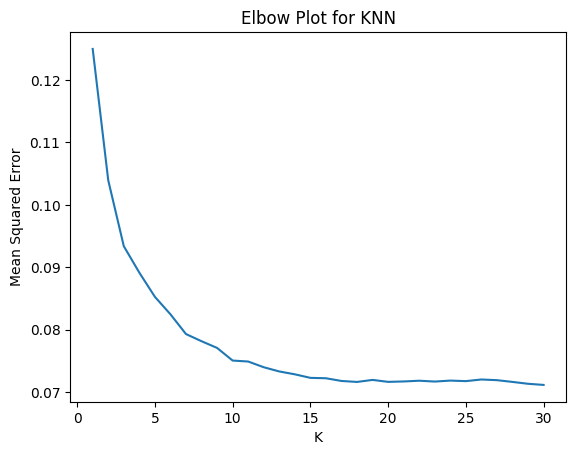

In [59]:
import matplotlib.pyplot as plt

# Define the range of K values
k_values = range(1, 31)

# Initialize an empty list to store the MSE values
mse_values = []

# Calculate the MSE for each K value
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_predictions = knn.predict(X_test)
    mse = mean_squared_error(y_test, knn_predictions)
    mse_values.append(mse)

# Plot the elbow plot
plt.plot(k_values, mse_values)
plt.xlabel('K')
plt.ylabel('Mean Squared Error')
plt.title('Elbow Plot for KNN')
plt.show()


In [60]:
X_train
X_test

,bathrooms,bedrooms,square_feet,latitude,longitude,pool,ac,parking,hot_tub,location_cluster,cats,dogs
8002,0.333333,0.2,0.000000,0.361208,0.746492,1.0,0.0,0.0,0.0,0.181818,1.0,1.0
8003,0.000000,0.2,0.000794,0.780083,0.641671,0.0,0.0,1.0,0.0,0.181818,1.0,1.0
8009,0.333333,0.2,0.001587,0.780083,0.641671,0.0,0.0,1.0,0.0,0.282828,1.0,0.0
8011,0.333333,0.2,0.001587,0.528154,0.870613,1.0,0.0,1.0,0.0,0.252525,1.0,1.0
8012,0.000000,0.0,0.001587,0.268725,0.394942,0.0,0.0,1.0,0.0,0.727273,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9769,0.666667,0.6,0.959524,0.176145,0.527949,0.0,0.0,0.0,0.0,0.424242,1.0,1.0
9782,0.333333,0.6,0.981746,0.295918,0.498681,0.0,0.0,0.0,0.0,0.181818,1.0,1.0
9783,0.333333,0.6,0.982540,0.366610,0.745915,0.0,0.0,0.0,0.0,0.181818,1.0,1.0
9792,0.333333,0.4,0.998413,0.295724,0.495162,0.0,0.0,0.0,0.0,0.000000,1.0,1.0


Best KNN Parameters: {'n_neighbors': 28}
KNN Mean Squared Error: 0.06200678893886326


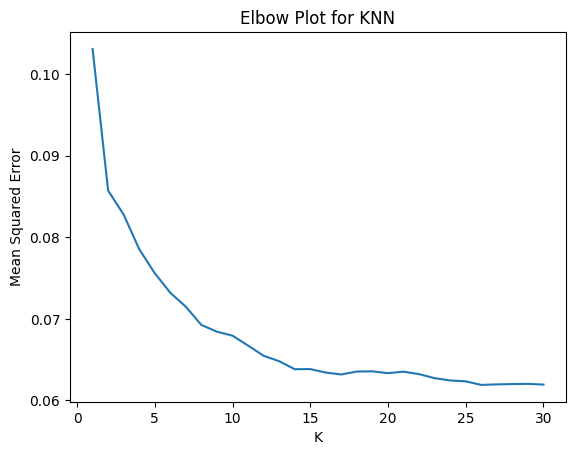

In [61]:
y_train = df_train['price']
X_train = df_train.drop(columns=['price'])

y_test = df_test['price']
X_test = df_test.drop(columns=['price'])

def min_max_normalize(X):
    return (X - X.min()) / (X.max() - X.min())

y_train = min_max_normalize(y_train)
y_test = min_max_normalize(y_test)

X_train = min_max_normalize(X_train)
X_test = min_max_normalize(X_test)

X_train = X_train[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]
X_test = X_test[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]


X_train = X_train[[
    # 'bathrooms',
    'bedrooms',
    'square_feet',
    # 'latitude',
    # 'longitude',
    'location_cluster',
    'pool',
    # 'ac',
    # 'parking',
    # 'hot_tub',
    'cats',
    # 'dogs'
]]
X_test = X_test[[
    # 'bathrooms',
    'bedrooms',
    'square_feet',
    # 'latitude',
    # 'longitude',
    'location_cluster',
    'pool',
    # 'ac',
    # 'parking',
    # 'hot_tub',
    'cats',
    # 'dogs'
]]

# vamos repetir o teste de KNN

# Definir os hiperparâmetros a serem ajustados
knn_params = {'n_neighbors': range(1, 31)}

# Inicializar o modelo
knn = KNeighborsRegressor()

# Configurar a validação cruzada com GridSearchCV
knn_grid = GridSearchCV(knn, knn_params, cv=10,
                        scoring='neg_mean_squared_error', n_jobs=-1)

# Treinar o modelo
knn_grid.fit(X_train, y_train)

# Melhor hiperparâmetro
print("Best KNN Parameters:", knn_grid.best_params_)

# Prever no conjunto de teste
knn_predictions = knn_grid.predict(X_test)

# Avaliar o modelo
knn_mse = mean_squared_error(y_test, knn_predictions)
print("KNN Mean Squared Error:", knn_mse)


# Definir os hiperparâmetros a serem ajustados
knn_params = {'n_neighbors': range(1, 31)}

# Initialize an empty list to store the MSE values
mse_values = []

# Calculate the MSE for each K value
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_predictions = knn.predict(X_test)
    mse = mean_squared_error(y_test, knn_predictions)
    mse_values.append(mse)

# Plot the elbow plot
plt.plot(k_values, mse_values)
plt.xlabel('K')
plt.ylabel('Mean Squared Error')
plt.title('Elbow Plot for KNN')
plt.show()

## Decision Tree


In [62]:
# preparacao dos dados 
df_train = df_train.loc[df_train.price < 2500]
y_train = df_train['price']
X_train = df_train.drop(columns=['price'])

y_test = df_test['price']
X_test = df_test.drop(columns=['price'])

def min_max_normalize(X):
    return (X - X.min()) / (X.max() - X.min())

y_train = min_max_normalize(y_train)
y_test = min_max_normalize(y_test)

X_train = min_max_normalize(X_train)
X_test = min_max_normalize(X_test)

X_train = X_train[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]
X_test = X_test[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]


In [63]:
# Definir os hiperparâmetros a serem ajustados
tree_params = {'max_depth': range(1, 8), 'min_samples_split': range(2, 21)}

# Inicializar o modelo
tree = DecisionTreeRegressor()

# Configurar a validação cruzada com GridSearchCV
tree_grid = GridSearchCV(tree, tree_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Treinar o modelo
tree_grid.fit(X_train, y_train)

# Melhor hiperparâmetro
print("Best Decision Tree Parameters:", tree_grid.best_params_)

# Prever no conjunto de teste
tree_predictions = tree_grid.predict(X_test)

# Avaliar o modelo
tree_mse = mean_squared_error(y_test, tree_predictions)
print("Decision Tree Mean Squared Error:", tree_mse)

Best Decision Tree Parameters: {'max_depth': 7, 'min_samples_split': 11}
Decision Tree Mean Squared Error: 0.1203903743777724


## Support Vector Machine (SVM)

In [64]:
# alterando features
# retirando bathrooms, latitude, longitude, ac, parking, hot_tub e dogs

X_train = X_train[[ 'bedrooms', 'square_feet', 'pool', 'location_cluster', 'cats']]
X_test = X_test[['bedrooms', 'square_feet', 'pool', 'location_cluster', 'cats']]

# Definir os hiperparâmetros a serem ajustados
svm_params = {'C': [0.1, 1, 10, 100], 'epsilon': [0.1, 0.2, 0.3], 'kernel': ['linear', 'poly', 'rbf']}

# Inicializar o modelo
svm = SVR()

# Configurar a validação cruzada com GridSearchCV
svm_grid = GridSearchCV(svm, svm_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Treinar o modelo
svm_grid.fit(X_train, y_train)

# Melhor hiperparâmetro
print("Best SVM Parameters:", svm_grid.best_params_)

# Prever no conjunto de teste
svm_predictions = svm_grid.predict(X_test)

# Avaliar o modelo
svm_mse = mean_squared_error(y_test, svm_predictions)
print("SVM Mean Squared Error:", svm_mse)

Best SVM Parameters: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
SVM Mean Squared Error: 0.048774758689782934


In [65]:
### Comparando os modelos
print("Resumo do Desempenho dos Modelos:")
print(f"KNN Mean Squared Error: {knn_mse*100:.2f} %")
print(f"Decision Tree Mean Squared Error: {tree_mse*100:.2f} %")
print(f"SVM Mean Squared Error: {svm_mse*100:.2f} %")

Resumo do Desempenho dos Modelos:
KNN Mean Squared Error: 6.20 %
Decision Tree Mean Squared Error: 12.04 %
SVM Mean Squared Error: 4.88 %


## MLP

In [66]:
# preparacao dos dados 
df_train = df_train.loc[df_train.price < 2500]
y_train = df_train['price']
X_train = df_train.drop(columns=['price'])

y_test = df_test['price']
X_test = df_test.drop(columns=['price'])

def min_max_normalize(X):
    return (X - X.min()) / (X.max() - X.min())

y_train = min_max_normalize(y_train)
y_test = min_max_normalize(y_test)

X_train = min_max_normalize(X_train)
X_test = min_max_normalize(X_test)

X_train = X_train[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]
X_test = X_test[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]

param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'alpha': [0.0001, 0.001],
    'solver': ['adam'],
    'learning_rate': ['constant', 'adaptive'],
}


## Criando o modelo

mlp_grid = GridSearchCV(MLPRegressor(max_iter=300, random_state=42), param_grid, cv=10, n_jobs=-1, verbose=2)
mlp_grid.fit(X_train, y_train)

# Melhor combinação de hiperparâmetros
print(f'Melhores hiperparâmetros: {mlp_grid.best_params_}')

# Avaliar a precisão no conjunto de teste
best_model = mlp_grid.best_estimator_
mlp_predictions = best_model.predict(X_test)

# Avaliar o modelo
mlp_mse = mean_squared_error(y_test, mlp_predictions)
print("MLP Mean Squared Error:", mlp_mse)


Fitting 10 folds for each of 8 candidates, totalling 80 fits
Melhores hiperparâmetros: {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
MLP Mean Squared Error: 0.056169891769155586


In [70]:
# preparacao dos dados 
df_train = df_train.loc[df_train.price < 2500]
y_train = df_train['price']
X_train = df_train.drop(columns=['price'])

y_test = df_test['price']
X_test = df_test.drop(columns=['price'])

def min_max_normalize(X):
    return (X - X.min()) / (X.max() - X.min())

y_train = min_max_normalize(y_train)
y_test = min_max_normalize(y_test)

X_train = min_max_normalize(X_train)
X_test = min_max_normalize(X_test)

X_train = X_train[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]
X_test = X_test[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'pool',
       'ac', 'parking', 'hot_tub', 'location_cluster', 'cats', 'dogs']]

## Criando o modelo de random forest

param_grid = {
    'n_estimators': [50,100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5, 12, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4, 8],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

rf_grid.fit(X_train, y_train)

# Avaliar a precisão no conjunto de teste
best_model = rf_grid.best_estimator_
rf_predictions = best_model.predict(X_test)

# Avaliar o modelo
rf_mse = mean_squared_error(y_test, rf_predictions)
print("Random Forest Mean Squared Error:", rf_mse)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
688 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ba

MLP Mean Squared Error: 0.06548279545803073


In [75]:
# Ajustar hiperparâmetros usando GridSearchCV
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.2],
    'n_estimators': [50,100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
xgb_grid.fit(X_train, y_train)

print("Melhores hiperparâmetros:", xgb_grid.best_params_)

best_xgb = xgb_grid.best_estimator_
y_pred_best = best_xgb.predict(X_test)

xgb_mse = mean_squared_error(y_test, y_pred_best)
print("XGBoost Mean Squared Error:", xgb_mse)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Melhores hiperparâmetros: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}
XGBoost Mean Squared Error: 0.06548279545803073
